In [2]:
import asyncio
import threading
import json
import time
import matplotlib.pyplot as plt
import networkx as nx
import websockets
import random


---
<br><br>
**$$Risk-Free\,\, Latency\,\, Arbitrage\,\, Strategy\,\, Model:$$**
<br><br>

---

<br><br><br><br><br>

## **1. Broker and Asset Sets**

Consider a closed set of brokers:

$$
\mathcal{B} = \{1, 2, \ldots, N\},
$$

where $N \in \mathbb{N}$ is the total number of brokers.

Similarly, consider a closed set of assets:

$$
\mathcal{A} = \{1, 2, \ldots, M\},
$$

where $M \in \mathbb{N}$ is the total number of assets.

Indices $i, j \in \mathcal{B}$ represent brokers, and $a \in \mathcal{A}$ an asset.

<br><br><br>
---

## **2. Asset Prices with Latency**

Let $P_i(a)(t)$ be the price of asset $a$ quoted by broker $i$ at time $t \geq 0$.

Due to latency, the observed price is:

$$
\tilde{P}_i(a)(t) := P_i(a)(t - \lambda_i),
$$

where $\lambda_i > 0$ is the latency for broker $i$.

<br><br><br>
---

## **3. Effective Price Difference Between Brokers**

The effective price difference between brokers $i$ and $j$ for asset $a$ at time $t$ is:

$$
\tilde{\Delta}_{i,j}(a)(t) := \left| \tilde{P}_i(a)(t) - \tilde{P}_j(a)(t) \right| = \left| P_i(a)(t - \lambda_i) - P_j(a)(t - \lambda_j) \right|.
$$

<br><br><br>
---

## **4. Arbitrage Signal and Instantaneous Profit**

With spread threshold $\tau(a) > 0$ (fees + slippage):

$$
\widetilde{\mathrm{Signal}}_{i,j}(a)(t) =
\begin{cases}
1, & \tilde{\Delta}_{i,j}(a)(t) > \tau(a), \\
0, & \text{otherwise}.
\end{cases}
$$

Instantaneous profit:

$$
\tilde{\rho}_{i,j}(a)(t) := \max\left(0, \tilde{\Delta}_{i,j}(a)(t) - \tau(a) \right).
$$

<br><br><br>
---

## **5. Formal Price Derivative**

To help understand price dynamics, consider the **formal** time derivative of the price (no approximation needed here):

$$
\frac{d P_i(a)}{dt}(t).
$$

This derivative is included for conceptual clarity — it can represent the instantaneous velocity of price changes, useful for understanding stability or smoothness of price evolution.

*Note:* This derivative is **not used** to filter or predict signals, just as a mathematical tool to simplify the system.

<br><br><br>
---

## **6. Total Delayed Profit**

Summing over assets and brokers (avoiding double counting with $j > i$):

$$
\tilde{\Pi} := \sum_{a=1}^M \sum_{i=1}^N \sum_{j=i+1}^N \int_0^T \Big[
\tilde{\rho}_{i,j}(a)(t) \cdot \widetilde{\mathrm{Signal}}_{i,j}(a)(t) +
\tilde{\rho}_{j,i}(a)(t) \cdot \widetilde{\mathrm{Signal}}_{j,i}(a)(t)
\Big] dt.
$$

<br><br><br>
---

## **7. Example: EUR/USD Arbitrage Between Two Brokers**

Let $N=2$, $M=1$ (EURUSD), at time $t_0 = 12:00:01$.

Given:

$$
\begin{cases}
P_1(1)(t_0) = 1.1040, \quad \lambda_1 = 20\, ms \\
P_2(1)(t_0) = 1.1032, \quad \lambda_2 = 30\, ms \\
\tau(1) = 0.0004 \quad (\text{fees + slippage})
\end{cases}
$$

Observed prices at $t_0$:

$$
\tilde{P}_1(1)(t_0) = P_1(1)(t_0 - 0.020), \quad
\tilde{P}_2(1)(t_0) = P_2(1)(t_0 - 0.030)
$$

Calculate the delayed price difference:

$$
\tilde{\Delta}_{1,2}(1)(t_0) = \left| \tilde{P}_1(1)(t_0) - \tilde{P}_2(1)(t_0) \right|.
$$

<br><br>

If $(\tilde{\Delta}_{1,2}(1)(t_0) > \tau(1))$, $\qquad$ then $(\tilde{\rho}_{1,2}(1)(t_0) = \tilde{\Delta}_{1,2}(1)(t_0) - \tau(1))$. $\qquad$ Otherwise $(\tilde{\rho}_{1,2}(1)(t_0) = 0.)$

<br><br><br><br><br>

---

<br>
The higher the volume per time unit and volatility and, on the other hand, the lower the spread, latency and fees, the more arbitrage opportunities are detected by the algorithm.
<br><br>

---


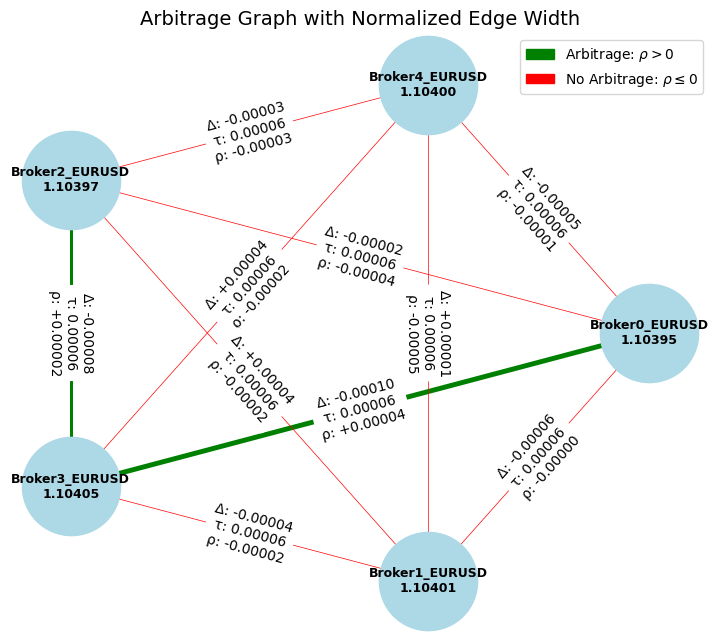

In [48]:
# Set of brokers: N = {0, 1, ..., N-1}
N = [f"Broker{i}" for i in range(0, 5)]  # N = 5

M = ["EURUSD"]
P̄ = {"EURUSD": 1.1040}

# Fixed Slippage + fees for simplification
slippage = 0.00002
fees = 0.00004
τ = {"EURUSD": slippage + fees}
P = {}

# Fake price updates
FAKE_WS_MESSAGES = {
    broker: json.dumps({
        "asset": "EURUSD",
        "price": round(P̄["EURUSD"] + random.uniform(-0.00006, 0.00006), 6)
    })
    for broker in N
}

async def simulate_websocket(broker, message):
    await asyncio.sleep(random.uniform(0.05, 0.25))
    data = json.loads(message)
    a = data["asset"]
    P[(broker, a)] = data["price"]
    #print(f"📥 {broker} → {a} = {P[(broker, a)]}")

async def receive_all():
    await asyncio.gather(*(simulate_websocket(b, msg) for b, msg in FAKE_WS_MESSAGES.items()))

await receive_all()

# Build graph
G = nx.Graph()

# Add nodes
for (i, a), price in P.items():
    G.add_node(f"{i}_{a}", price=price, broker=i, asset=a)

# Add edges with normalized thickness
for i_idx in range(len(N)):
    for j_idx in range(i_idx + 1, len(N)):
        i, j = N[i_idx], N[j_idx]
        a = "EURUSD"
        Pi, Pj = P[(i, a)], P[(j, a)]
        Δ = Pi - Pj
        Δ_abs = abs(Δ)
        τ_val = τ[a]
        ρ = Δ_abs - τ_val

        # Colores y grosor normalizado por rentabilidad relativa
        color = "green" if ρ > 0 else "red"
        if ρ > 0 and Δ_abs > 0:
            width = 0.5 + 8 * (ρ / Δ_abs)
        else:
            width = 0.5

        G.add_edge(
            f"{i}_{a}", f"{j}_{a}",
            price_diff_signed=Δ,
            slippage=slippage,
            fees=fees,
            tau=τ_val,
            rho=ρ,
            color=color,
            width=width
        )

# Visualización
pos = nx.circular_layout(G)
node_labels = {
    n: f"{n}\n{G.nodes[n]['price']:.5f}" for n in G.nodes
}

edge_labels = {}
for u, v in G.edges:
    e = G[u][v]
    edge_labels[(u, v)] = (
        f"Δ: {e['price_diff_signed']:+.5f}\n"
        f"τ: {e['tau']:.5f}\n"
        f"ρ: {e['rho']:+.5f}"
    )

edge_colors = [G[u][v]['color'] for u, v in G.edges]
edge_widths = [G[u][v]['width'] for u, v in G.edges]

plt.figure(figsize=(7, 6))
nx.draw(G, pos, with_labels=True, labels=node_labels,
        edge_color=edge_colors, width=edge_widths,
        node_color='lightblue', node_size=5000,
        font_size=9, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

plt.title(r"Arbitrage Graph with Normalized Edge Width", fontsize=14)
plt.axis('off')

import matplotlib.patches as mpatches
plt.legend(
    handles=[
        mpatches.Patch(color='green', label=r"Arbitrage: $\rho > 0$"),
        mpatches.Patch(color='red', label=r"No Arbitrage: $\rho \leq 0$")
    ],
    loc='upper right'
)

plt.show()

---

<br><br>
**$$Latency\text{-}Aware\ Arbitrage\ Optimization$$**
<br><br>

---

<br><br><br><br><br>
## **1. Latency-Aware Arbitrage Optimization**

Given the undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$, where each node represents a broker quoting the same asset and each edge $(i,j)$ is annotated with:

- $\tilde{\rho}_{i,j}$: delayed profit margin  
- $\lambda_{i,j}$: end-to-end execution latency  

we define the **latency-adjusted utility function** as:

$$
\text{Utility}_{i,j} := \frac{\tilde{\rho}_{i,j}}{\lambda_{i,j}}.
$$

<br>

The goal is no longer to simply sort by raw profit $\tilde{\rho}_{i,j}$, but to identify the **optimal combination of arbitrage opportunities** maximizing total expected utility under time constraints.

<br><br><br>

##**2. Execution Order & Problem Nature**

This is analogous to a **Time-Constrained Traveling Salesman Problem (TSP)**, where:

- Nodes = brokers  
- Edges = arbitrage opportunities  
- We must **start with the edge of highest utility (green)** and progressively follow decreasing utility values, ensuring:

  - The accumulated latency $\sum \lambda_{i,j} \leq T$
  - Capital, liquidity, and other constraints remain satisfied.

<br><br><br>


##**3. Computational Complexity Summary**

Problem Variant: Best single edge by $\text{Utility}_{i,j}$  | Complexity: $\mathcal{O}(n^2)$ 2 because of both variables to consider  
Problem Variant: Most profitable path with $\sum \lambda_{i,j} \leq T$ (TSP-style)  | Complexity: NP-Hard  
Problem Variant: Optimal edge set under full constraints (latency, slippage, etc.)  | Complexity: NP-Hard
<br><br><br><br><br>


---
<br>
This formulation extends classic arbitrage into a latency-aware optimization space, requiring combinatorial reasoning under hard constraints. Efficient approximations or heuristics may be necessary in realistic scenarios. Maybe quantum computing QKE system or HPC can show an edge (but just in the case that latency is not a priority and there are >10k nodes not for 5)
<br> <br>

---


In [50]:
print("\n--- Simulating trades on edges with positive arbitrage ---\n")

trades = []

# Filtrar aristas con rho > 0 (arbitrage positivo) y ordenarlas descendente
positive_edges = [(u, v, attr) for u, v, attr in G.edges(data=True) if attr['rho'] > 0]
positive_edges.sort(key=lambda x: x[2]['rho'], reverse=True)

for u, v, attr in positive_edges:
    rho = attr['rho']
    price_u = G.nodes[u]['price']
    price_v = G.nodes[v]['price']

    # Comprar al precio menor y vender al mayor
    if price_u < price_v:
        buy_broker, sell_broker = u, v
        buy_price, sell_price = price_u, price_v
    else:
        buy_broker, sell_broker = v, u
        buy_price, sell_price = price_v, price_u

    trade_info = {
        "buy_broker": buy_broker,
        "sell_broker": sell_broker,
        "buy_price": buy_price,
        "sell_price": sell_price,
        "net_spread": rho
    }
    trades.append(trade_info)
    print(f"Open trade: Buy from {buy_broker} at {buy_price:.6f}, "
          f"sell to {sell_broker} at {sell_price:.6f} - Net profit: {rho:.6f}")

if not trades:
    print("No positive arbitrage opportunities to open trades.")



--- Simulating trades on edges with positive arbitrage ---

Open trade: Buy from Broker0_EURUSD at 1.103950, sell to Broker3_EURUSD at 1.104047 - Net profit: 0.000037
Open trade: Buy from Broker2_EURUSD at 1.103971, sell to Broker3_EURUSD at 1.104047 - Net profit: 0.000016
